# Autoregressive flows and RealNVP

In [1]:
from IPython.display import Image

This reading contains an overview of normalising flows, and introduces two popular normalising flow models: masked autoregressive flow (MAF) and RealNVP.

You'll also learn about the considerations in different architectures and the tradeoff between computational complexity and learning power.

## Introduction

Before any theory, we'll discuss an example of how normalizing flows work. Suppose you have a standard normal distribution (mean 0, variance 1). It has a single mode at 0, so, even after scaling and shifting, can't be fit well to data with two modes. However, you've seen how bijectors applied to distributions can create other distributions. A natural question is then: can we create a bimodal distribution (one with two modes) from a bijector applied to a standard normal distribution? It turns out that this is possible with the `Softsign` bijector. This is a differentiable approximation to the sign function (1 if $x$ is nonnegative, -1 if $x$ is negative). Passing a standard normal distribution through this bijector transforms the probability distribution as follows:

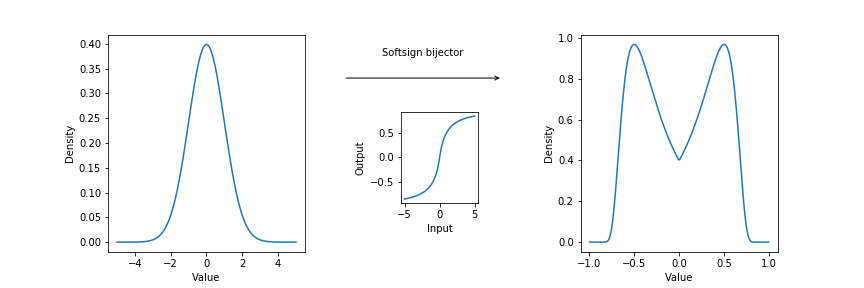

In [2]:
# Run this cell to download and view an example transformed distribution

!wget -q -O normal_to_bimodal.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1H8hY33aWjmpoa_mqAKQ7Xma2yfR6vr2E"
Image("normal_to_bimodal.png", width=1000)

As you can see, the bijector created a bimodal distribution from a standard normal one! This is just one from a huge class of possible bijectors available in TensorFlow Probability. Furthermore, since you can chain them together, it's possible to create very complicated bijectors that change standard distributions (e.g. a normal) to very complicated ones. This is how a normalizing flow works: it creates a complicated distribution by applying a bijector to a simple, well-understood and computationally implemented distribution (such as a Gaussian). In this reading, you'll learn how this works and see some implementations from previous research.

## Normalizing flows

### The one-dimensional case

The main idea of normalizing flows is to create a random variable $X$ (with complicated distribution $P$) by applying a bijector $f$ to a random variable $Z$ (with a simple distribution). For example, suppose $Z \sim N(0, 1)$ has a standard normal distribution. The goal is to find a bijector $f$ so that $ X = f(Z) \sim P $ for some target distribution $P$. Under this transformation, we can calculate the log-density using the change of variables equation:
$$ \log p(x) = \log p(z) - \log \left| \frac{\partial f}{\partial z}(z) \right| $$
where $z = f^{-1}(x)$.

Finding an $f$ that changes the distribution as required is not trivial: if the target distribution $P$ is very complex, a simple $f$ (such as a scale or shift) won't do the trick. However, we know that composing bijectors with one another creates more bijectors. Hence, one approach is to combine multiple simple bijectors $f_k$ to create a more complicated $f$:
$$ f = f_K \circ f_{K-1} \circ \ldots \circ f_1. $$

This series, where a base distribution is transformed by a series of bijectors after each other, is called a *normalizing flow*:
$$ z_0 = z$$
$$ z_k = f_k(z_{k-1}) \quad k=1, \ldots, K. $$
$$ x = z_K $$
Furthermore, the log-probability can be calculated by summing the contributions from each of the bijectors:
$$ \log p(x) = \log p(z) - \sum_{k=1}^K \log \left| \frac{\partial f_k}{\partial z_{k-1}}(z_{k-1}) \right| $$

This, however, still doesn't answer the question of how to construct the $f_k$. Usually, this is done by giving each $f_k$ some simple functional form, such as a scale and shift followed by a simple nonlinearity such as a sigmoid or ReLU. Each $f_k$ will have some parameters (such as the scale and shift values), and these can be learned via standard methods such as maximum likelihood estimation given some training data.

### The higher-dimensional case

The results above generalise straightforwardly to higher dimensions. Suppose that $\mathbf{z} \sim N(0, \mathbf{I})$ is distributed according to a multivariate unit Gaussian. The normalizing flow is then
$$ \mathbf{z}_0 = \mathbf{z}$$
$$ \mathbf{z}_k = \mathbf{f}_k(\mathbf{z}_{k-1}) \quad k=1, \ldots, K. $$
The log-probability involves the determinant of the transformation, as you'll remember from an earlier reading:
$$ \log p(\mathbf{x}) = \log p(\mathbf{z}) - \sum_{k=1}^K \log \left(\left| \det \left( \frac{\partial \mathbf{f}_k}{\partial \mathbf{z}_{k-1}}(\mathbf{z}_{k-1}) \right) \right|\right) $$
where we use the shorthand notation $\frac{\partial \mathbf{a}}{\partial \mathbf{b}}$ for the matrix with components $\frac{\partial \mathbf{a}_i}{\partial \mathbf{b}_j}$, where $i$ and $j$ index the components of $\mathbf{a}$ and $\mathbf{b}$ respectively.

Let's see an example of this from an [early research paper](https://arxiv.org/abs/1505.05770). In the figure below, the left column is the density of the target distribution $P$, and the right columns are the normalizing flow approximations with $K$=2, 8 and 32 bijectors (each with a simple form and some trainable parameters).

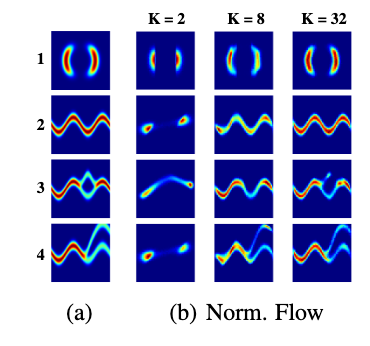

In [3]:
# Run this cell to download and view example normalising flow approximations

!wget -q -O normalising_flow.png --no-check-certificate "https://docs.google.com/uc?export=download&id=16t_qyKcx3PblwB2ZRo4D0PDSxPmEugvh"
Image("normalising_flow.png", width=600)

As you can see, the approximation improves as the number of bijectors in the flow increases. 

The reason this is useful is that it allows us to "learn" a complex distribution from data and then manipulate it. For example, to draw a new sample from the learned distribution, simply draw $\mathbf{z}$ from a standard unit Gaussian and transform it to the correct space using the normalizing flow (the series of bijectors).

**Note**: Throughout this reading, we use the index $k$ to refer to the bijector in the normalizing flow and indices $i$ and $j$ to refer to dimensions of the probability space (from 1 to $D$). From here on, for clarity, we consider a normalizing flow formed of only one bijector (with $K=1$), so that we may drop the indices $k$. The equation becomes $\mathbf{x} = \mathbf{f}(\mathbf{z})$. The reason for doing this is that we now use indices to refer to components of the vectors (e.g. $\mathbf{x} = [x_1, \ldots, x_D]^T)$ where $D$ is the dimensionality. For normalizing flows with $K>1$, the results apply for each $k$.

### Computational concerns

The above theory provides, in principle, a framework to learn and manipulate complex distributions by building them up from a simple one. There is one key difficulty, however, when going to a practical implementation. This comes from the need to calculate the determinant $\left| \det \left( \frac{\partial \mathbf{f}}{\partial \mathbf{z}} \right) \right|$ to determine the density of the transformed variable $\mathbf{x}$. The computational cost (number of operations) to calculate a determinant for a general matrix with $D$ dimensions scales as $\mathcal{O}(D^3)$. This makes general normalizing flow density calculations intractable, and some simplifications, as outlined below, are required.

### Autoregressive flows

For some matrices, calculating a determinant is easy. For example, for a lower or upper triangular matrix, the determinant is the product of the diagonal elements, of which there are $D$, meaning the determinant calculation scales linearly. Hence, to attain a linear scaling of the determinant in the number of dimensions, it is enough to enforce that $\frac{\partial f_i}{\partial z_j} = 0$ whenever $j > i$. In other words, the component $f_i$ depends only on $z_1, \ldots z_i$.

Autoregressive models can be reinterpreted as normalising flows that fulfil this requirement. These are models that model the joint density $p(\mathbf{x})$ as the product of conditionals $\prod_i p(x_i \mid \mathbf{x}_{1:i-1})$. For example, the conditionals could be parameterised as Gaussians:

$$
\begin{align}
p(x_i \mid\mathbf{x}_{1:i-1}) &= \mathcal{N}(x_i\mid\mu_i, \exp(\sigma_i)^2),\\
\text{where}\qquad \mu_i &= f_{\mu_i}(\mathbf{x}_{1:i-1})\\
\text{and}\qquad \sigma_i &= f_{\sigma_i}(\mathbf{x}_{1:i-1}).
\end{align}
$$

In the above equations, the mean and standard deviations of each conditional distribution are computed using (parameterised) functions of all previous variables. The above can alternatively be written as:

$$ x_i = \mu_i(\mathbf{x}_{1:i-1}) + \exp(\sigma_i(\mathbf{x}_{1:i-1})) z_i \quad \quad i=1, \ldots, D$$

where $z_i \sim N(0, 1)$ is sampled from a unit Gaussian. This last equation shows how the autoregressive model can be viewed as a transformation $f$ from the random variables $\mathbf{z}\in\mathbb{R}^D$ to the data $\mathbf{x}\in\mathbb{R}^D$.


This is an example of an *autoregressive* process where $x_i$ depends only on the components of $\mathbf{z}$ that are lower than or equal to $i$ but not any of the higher ones. The dependence on lower dimensions of $\mathbf{z}$ happens indirectly through the $x_i$ dependence in the $f_{\mu_i}$ and $f_{\sigma_i}$.

## Implementations 

### Masked Autoregressive Flow (MAF)

An implementation of the above autoregressive flow appears in the following paper:
- George Papamakarios, Theo Pavlakou, Iain Murray (2017). [Masked Autoregressive Flow for Density Estimation](http://papers.nips.cc/paper/6828-masked-autoregressive-flow-for-density-estimation.pdf). In *Advances in Neural Information Processing Systems*, 2017. 

Here, the authors use the above equations, using a masked autoencoder for distribution estimation ([MADE](http://proceedings.mlr.press/v37/germain15.pdf)) to implement the functions $f_{\mu_i}$ and $f_{\sigma_i}$. For clarity, let's see how $\mathbf{x}$ is sampled. This is done as follows:
1. $x_1 = f_{\mu_1} + \exp(f_{\sigma_1})z_1$ for $z_1 \sim N(0, 1)$
2. $x_2 = f_{\mu_2}(x_1) + \exp(f_{\sigma_2}(x_1))z_2$ for $z_2 \sim N(0, 1)$
2. $x_3 = f_{\mu_3}(x_1, x_2) + \exp(f_{\sigma_3}(x_1, x_2))z_3$ for $z_3 \sim N(0, 1)$ 

and so on. For the $f_{\mu_i}$ and $f_{\sigma_i}$, they use the same MADE network across the $i$, but mask the weights so that $x_i$ depends on $x_j$ for all $j<i$ but not any others. By re-using the same network, weights can be shared and the total number of parameters is significantly lower.

A note on computational complexity: determining $\mathbf{x}$ from $\mathbf{z}$ is relatively slow, since this must be done sequentially: first $x_1$, then $x_2$, and so on up to $x_D$. However, determining $\mathbf{z}$ from $\mathbf{x}$ is fast: each of the above equations can be solved for $z_i$ at the same time:
$$ z_i = \frac{x_i - f_{\mu_i}}{\exp(f_{\sigma_i})} \quad \quad i=0, \ldots, D-1$$
Hence, the *forward* pass through the bijector (sampling $\mathbf{x}$) is relatively slow, but the *inverse* pass (determining $\mathbf{z}$), which is used in the likelihood calculations used to train the model, is fast. 


### Inverse Autoregressive Flow (IAF)

The inverse autoregressive flow reverses the dependencies to make the forward pass parallelisable but the inverse pass sequential. Details can be found in the following paper:
- Diederik Kingma, Tim Salimans, Rafal Jozefowicz, Xi Chen, Ilya Sutskever, Max Welling (2016). [Improved Variational Inference with Inverse Autoregressive Flow](http://papers.nips.cc/paper/6581-improved-variational-inference-with-inverse-autoregressive-flow.pdf). In *Advances in Neural Information Processing Systems*, 2016.


It uses the same equations:

$$ x_i = \mu_i + \exp(\sigma_i) z_i \quad \quad i=1, \ldots, D$$

but has the scale and shift functions depend on the $z_i$ instead of the $x_i$:

$$ \mu_i = f_{\mu_i}(z_1, \ldots, z_{i-1}) \quad \quad \sigma_i = f_{\sigma_i}(z_1, \ldots, z_{i-1}).$$

Note that now the forward equation (determining $\mathbf{x}$ from $\mathbf{z}$) can be parallelised, but the reverse transformations require determining $z_1$, followed by $z_2$, etc. and must hence be solved in sequence.

### Real-NVP and NICE

A further simplification of these approaches can be found in these papers:
- Laurent Dinh, Jascha Sohl-Dickstein, Samy Bengio (2016). [Density estimation using Real NVP](https://arxiv.org/abs/1605.08803). 
- Laurent Dinh, David Krueger, Yoshua Bengio (2014). [NICE: Non-linear Independent Components Estimation](https://arxiv.org/abs/1410.8516).

The first uses a reduced versions of the above equations, for some chosen $L$:

$$
\begin{align}
x_i &= z_i \qquad &i = 1, \ldots, d \\
x_i &= \mu_i + \exp(\sigma_i) z_i \qquad &i = d+1, \ldots D 
\end{align}
$$

where 

$$ 
\begin{align}
\mu_i &= f_{\mu_i}(z_1, \ldots, z_{d})\\
\sigma_i &= f_{\sigma_i}(z_1, \ldots, z_{d})
\end{align}
$$

Hence, nothing happens for the first $d$ dimensions, but the $z_i$ values across these values transform the $x_i$ values for remaining $D-d$. Note that, in this case, both the forward and backward pass of the flow can be done fully in parallel. The second paper is even simpler, and omits the scale term altogether.

There is, of course, a catch: such a simple form means the flow typically needs a lot of bijections (a high $K$ value) to be able to describe complicated distributions. Furthermore, the dimensions that are transformed ($D-L$ in total) and not transformed ($L$ in total) must be permuted in the different bijections: otherwise the first $L$ dimensions of $\mathbf{z}$ are never changed throughout the whole normalizing flow, which greatly limits the expressive power. You'll be creating such a normalizing flow in this week's programming assignment.

### Further reading and resources

Besides the papers cited above, there are two great blog posts that explain that material as well:
- [Normalizing Flows](http://akosiorek.github.io/ml/2018/04/03/norm_flows.html) by Adam Kosiorek
- [Normalizing Flows Tutorial](https://blog.evjang.com/2018/01/nf1.html) by Eric Jang.

Both of these offer slightly more detail than we have space for here. They also have some great visuals. Happy reading and have fun implementing these ideas in the next few lessons!